<a href="https://colab.research.google.com/github/makaveli10/NLP/blob/master/transformer_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This trains a transformer model to be a chatbot. Please refer to the original paper  [Attention is all you need](https://arxiv.org/abs/1706.03762) for detailed information about the transofrmer. The core idea behind the transformer is self attention. 

In [2]:
from __future__ import absolute_import, division, unicode_literals, print_function

!pip install tf-nightly-gpu-2.0-preview==2.0.0.dev20190520
import tensorflow as tf

!pip install tfds-nightly
import tensorflow_datasets as tfds

import os
import re
import numpy as np

import matplotlib.pyplot as plt

Create dataset pipeline with tf.data. Download cornell moview dialogues which are 220k conversational exchanges between 10k pair of movie characters. 

movie_conversations.txt contains list of the conversation IDs and movie_lines.text contains the text of assoicated with each conversation ID. For further information regarding the dataset, please check the README file in the zip file.

In [0]:
# download file using tensorflow keras util
path_to_zip = tf.keras.utils.get_file('cornell_movie_dialogs.zip',
                                      origin= 'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
                                      extract=True)

path_to_dataset = os.path.join(os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset, 'movie_conversations.txt')

**Dataset Pipeline**

We are going to build the input pipeline with the following steps:


*   Preprocess each sentence by removing special characters in each sentence.
*   Build tokenizer (map text to ID and ID to text) with TensorFlow Datasets SubwordTextEncoder.
*   Tokenize each sentence and add START_TOKEN and END_TOKEN to indicate the start and end of each sentence.
*   Filter out sentences that contain more than MAX_LENGTH tokens.
*   Build tf.data.Dataset with the tokenized sentences


In [0]:
MAX_SAMPLES = 50000

# remove special characters
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # substitute space before each punctuation i.e. creating a space between
  # word and punctuatuion following it
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  
  # replacing everything with space except (a-z, A-z, "?", ",", ".", "!")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

def load_conv():
  with open(path_to_movie_lines, errors='ignore') as f:
    lines = f.readlines()
  id_to_lines = {}
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id_to_lines[parts[0]] = parts[4]
  
  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    # get conversation in a list of line ID
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
    for i in range(len(conversation)-1):
      inputs.append(preprocess_sentence(id_to_lines[conversation[i]]))
      outputs.append(preprocess_sentence(id_to_lines[conversation[i+1]]))
      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs

ques, ans = load_conv()

In [5]:
print('Sample question: {}'.format(ques[20]))
print('Sample answer: {}'.format(ans[20]))

Sample question: i really , really , really wanna go , but i can t . not unless my sister goes .
Sample answer: i m workin on it . but she doesn t seem to be goin for him .


In [0]:
# Build tokenizer (map text to ID and ID to text) with TensorFlow Datasets SubwordTextEncoder
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(ques + ans, target_vocab_size=2**13)
# define start and end token
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

In [7]:
# tokenize sample question
print('Tokenized sample question: {}'.format(tokenizer.encode(ques[20])))

Tokenized sample question: [4, 281, 3, 281, 3, 143, 395, 176, 3, 42, 4, 38, 8191, 2, 37, 873, 27, 2031, 3096, 1]


In [0]:
MAX_LENGTH = 40

# Pad tokenized sentences to MAX_LENGTH
def tokenize_and_pad_seq(inputs, outputs):
  tokenize_inp, tokenize_out = [], []
  for sent_1, sent_2 in zip(inputs, outputs):
    sent_1 = START_TOKEN + tokenizer.encode(sent_1) + END_TOKEN
    sent_2 = START_TOKEN + tokenizer.encode(sent_2) + END_TOKEN
    if len(sent_1) <= MAX_LENGTH and len(sent_2) <= MAX_LENGTH:
      tokenize_inp.append(sent_1)
      tokenize_out.append(sent_2)
    
  # pad smaller sequences
  tokenize_inp = tf.keras.preprocessing.sequence.pad_sequences(tokenize_inp,
                                                               maxlen=MAX_LENGTH,
                                                               padding='post')
  tokenize_out = tf.keras.preprocessing.sequence.pad_sequences(tokenize_out,
                                                               maxlen=MAX_LENGTH,
                                                               padding='post')
  return tokenize_inp, tokenize_out

ques, ans = tokenize_and_pad_seq(ques, ans)

In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
      'inputs' : ques,
      'dec_inputs' : ans[:, :-1]
    },
    {
      'outputs' : ans[:, 1:] 
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

**SCALED DOT PRODUCT ATTENTION**

This attention takes three inputs i.e query, key and value :

*Attention(Q, K, V) = softmax((QK(T))/sqrt(dim(Key))) * V* 

The softmax normalization depends on key, its values decides the importance given to the query, which is then ,ultiplied by value vector to flush out irrelevant words and keep only those to be focused on.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of query and key and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.



In [0]:
def scaled_dot_attention(query, key, values, mask):
  mul_qk = tf.matmul(query, key, transpose_b=True)
  dim_k = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = mul_qk / tf.math.sqrt(dim_k)
  
  # add the mask zero out padding tokens.
  if mask is not None:
    logits += (mask * 1e-9)
    
  soft_attention = tf.nn.softmax(logits)
  
  return tf.matmul(soft_attention, values)

**Multi Head attention layer**

Using Model subclassing to implement our MultiHeadAttention layer.


*   Linear layer and split into head
*   Scaled dot product attention
*   Concatenation of heads
*   Final linear layer

When using Model subclassing with Functional API, inputs has to be kept a single argument, hence wrap query, key and value as dictionary.

Instead of single attention head, query, key and value are split into multiple heads so that model can jointly attend to information at diffenrent postion from different representational spaces. Linearly projecting queries, keys and values multiple times.





In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, num_heads, d_model, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.d_model = d_model
    self.num_heads = num_heads
    
    assert d_model % self.num_heads == 0
    
    self.depth = self.d_model // self.num_heads
    
    self.query_dense = tf.keras.layers.Dense(units=self.d_model)
    self.key_dense = tf.keras.layers.Dense(units=self.d_model)
    self.value_dense = tf.keras.layers.Dense(units=self.d_model)
    
    self.dense = tf.keras.layers.Dense(units=self.d_model)
    
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(inputs,
                        shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])
  
  def call(self, inputs):
    # extract query, key and value
    query = inputs['query']
    key = inputs['key']
    value = inputs['value']
    mask = inputs['mask']
    batch_size = tf.shape(value)[0]
    
    # linear
    query = self.query_dense(query)
    key  = self.key_dense(key)
    value = self.value_dense(value)
    
    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)
    
    # scaled dot attention
    scaled_attention = scaled_dot_attention(query, key, value, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    
    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  shape=(batch_size, -1, self.d_model))
    
    #final linear layer
    outs = self.dense(concat_attention)
    return outs
    

# Transformer
**Positional Encoding**


---



Since, the model contains no convolution or recurrence. They injected positional information by adding positional encodings to the input embeddings.

In [0]:

class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

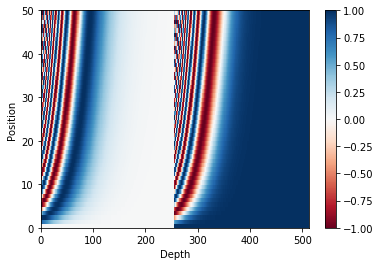

In [13]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

**Masking**

---
Helper functions *create_padding_mask* and *create_look_ahead_mask* to mask out padded tokens.

Mask all the pad tokens (value 0) in the batch to ensure the model does not treat padding as input.

In [14]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x,0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :]        # (batch_size, 1, 1, sequence length)


print(create_padding_mask(tf.constant([[1,2,4,0,1], [0,0,0,0,1]])))

tf.Tensor(
[[[[0. 0. 0. 1. 0.]]]


 [[[1. 1. 1. 1. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


Look ahead mask for the decoder layer to mask out the fututre tokens. We dont need the x+1th token to predict the xth token.

In [0]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [16]:
print(create_look_ahead_mask(tf.constant([[4, 0, 0, 3, 2]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 1. 1. 1. 1.]
   [0. 1. 1. 1. 1.]
   [0. 1. 1. 0. 1.]
   [0. 1. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


**Transformer with Functional API**

---

With functional API, we can stack over layers similar to sequential model but without the constraint of it being a sequential model and without declaring all the variables and layers in advance as in model subclassing.


**Encoder Layer**


---


*   Multi head attention (with padding mask)
*   2 Feed forward dense layers with dropout




In [0]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  attention = MultiHeadAttention(
                       num_heads, d_model, name="attention")({'query' : inputs, 
                                                              'key' : inputs,
                                                              'value' : inputs,
                                                              'mask' : padding_mask})
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
  
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

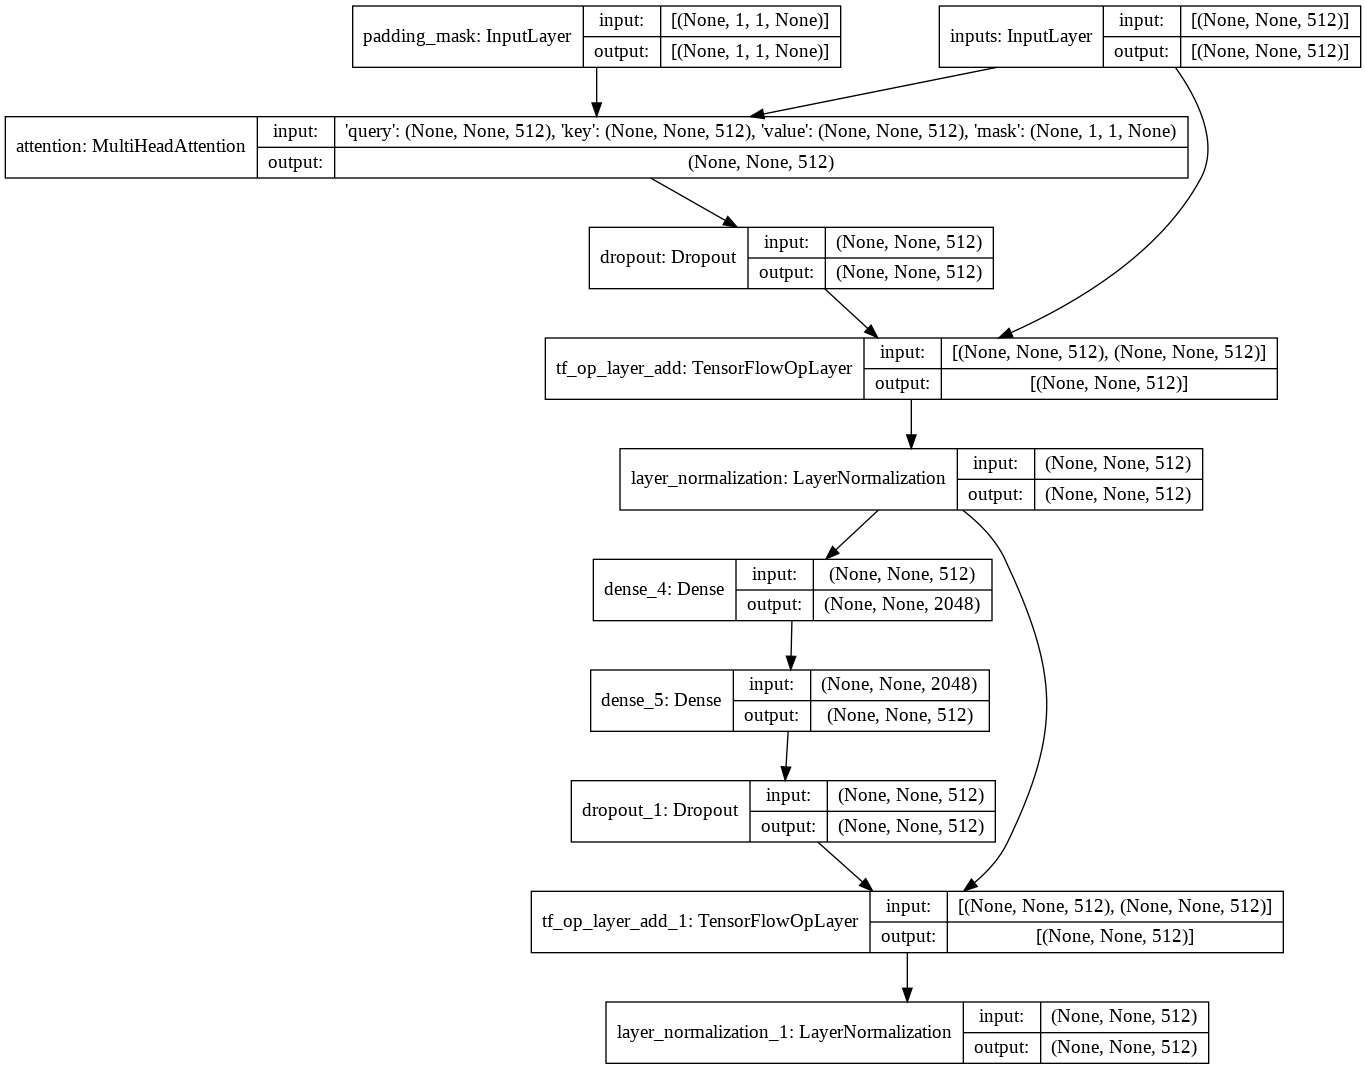

In [18]:
eg_enc_model = encoder_layer(units=2048,
                             d_model=512,
                             num_heads=16,
                             dropout=0.5,
                             name="eg_enc_layer")
tf.keras.utils.plot_model(eg_enc_model,
                          to_file='eg_enc_layer.png',
                          show_shapes=True)

**Encoder**

Encoder has


*   Input embedding
*   Positional Embedding
*   Encoder Layers


In [0]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.layers.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.layers.Input(shape=(1, 1, None), name="padding_mask")
  
  embeddings = tf.keras.layers.Embedding(input_dim=vocab_size,
                                         output_dim=d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
  
  for i in range(num_layers):
    outputs = encoder_layer(units=units,
                            d_model=d_model,
                            num_heads=num_heads,
                            dropout=dropout,
                            name="encoder_layer_{}".format(i))([outputs, padding_mask])
  return tf.keras.Model(inputs=[inputs, padding_mask],
                        outputs=outputs,
                        name=name)

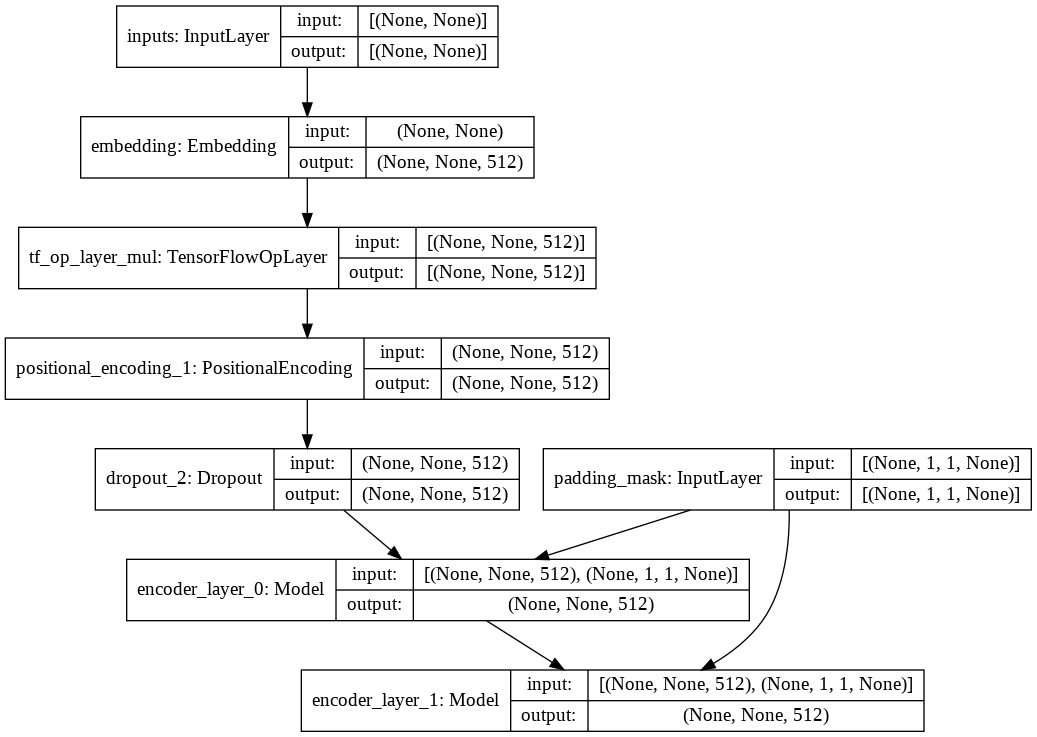

In [20]:
sample_encoder = encoder(vocab_size=8192,
                         num_layers=2,
                         units=2048,
                         d_model=512,
                         num_heads=16,
                         dropout=0.5,
                         name="sample_encoder")
tf.keras.utils.plot_model(sample_encoder,
                          to_file='encoder.png',
                          show_shapes=True)

**Decoder Layer**


---

In addition to the two sublayers in the encoder, the decoder inserts a third sublayer which performs multi head attention over the outputs of the encoder stack.

*   Masked Multi head attention(with look ahead mask and padding mask)
*  Multi head attention(with padding mask) over the outputs of the encoder. Value and key from enc as inputs. Query recieved from decoder's masked multi head attention.
*   2 of them Dense Layers

The decoder predicts the next word by looking at the encoder outputs and its own self attention.

In [0]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.layers.Input(shape=(None, d_model), name="inputs")
  enc_outs = tf.keras.layers.Input(shape=(None, d_model), name="enc_outputs")
  look_ahead_mask = tf.keras.layers.Input(shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.layers.Input(shape=(1, 1, None), name="padding_mask")
  
  attention_self = MultiHeadAttention(num_heads,
                                      d_model,
                                      name="attention_1")(inputs={'query' : inputs, 
                                                                  'key' : inputs,
                                                                  'value' : inputs,
                                                                  'mask' : look_ahead_mask})
  attention_self = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_self + inputs)
  attention_2 = MultiHeadAttention(num_heads, 
                                   d_model, 
                                   name="attention_2")(inputs={'query' : attention_self, 
                                                               'key' : enc_outs,
                                                               'value' : enc_outs,
                                                               'mask' : padding_mask})
  attention_2 = tf.keras.layers.Dropout(rate=dropout)(attention_2)
  attention_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_2 + attention_self)
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention_2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention_2)
  return tf.keras.Model(inputs=[inputs, enc_outs, look_ahead_mask, padding_mask],
                        outputs=outputs,
                        name=name)

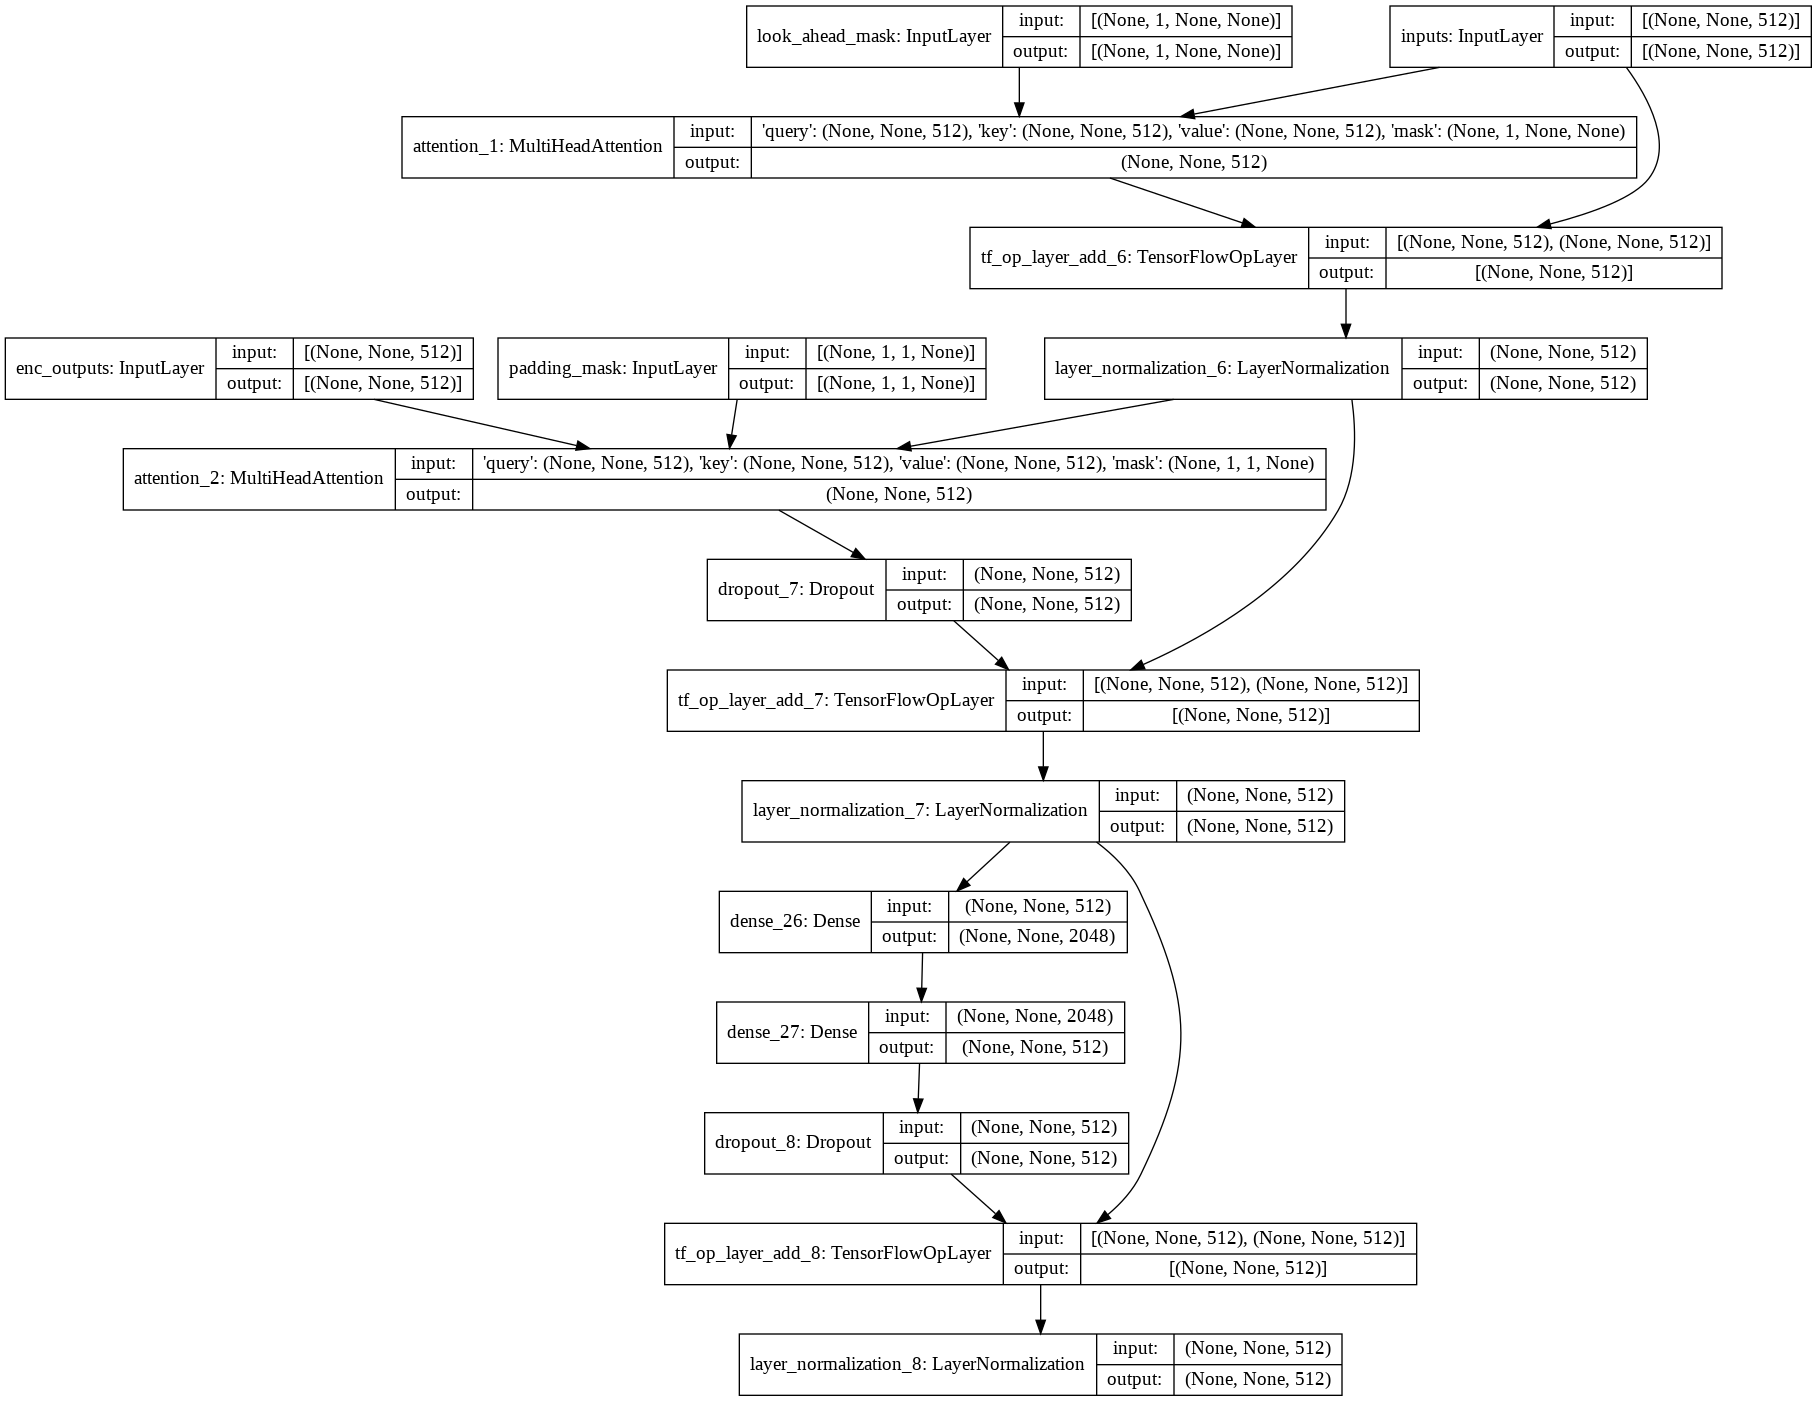

In [22]:
sample_decoder_layer = decoder_layer(
    units=2048,
    d_model=512,
    num_heads=16,
    dropout=0.5,
    name="eg_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

**Decoder**


---

The decoder has:
*   Output Embedding
*   Positional Encoding
*   N decoder layers

In [0]:

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(units=units,
                            d_model=d_model,
                            num_heads=num_heads,
                            dropout=dropout,
                            name='decoder_layer_{}'.format(i))([outputs,
                                                                enc_outputs,
                                                                look_ahead_mask,
                                                                padding_mask])

  return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                        outputs=outputs,
                        name=name)

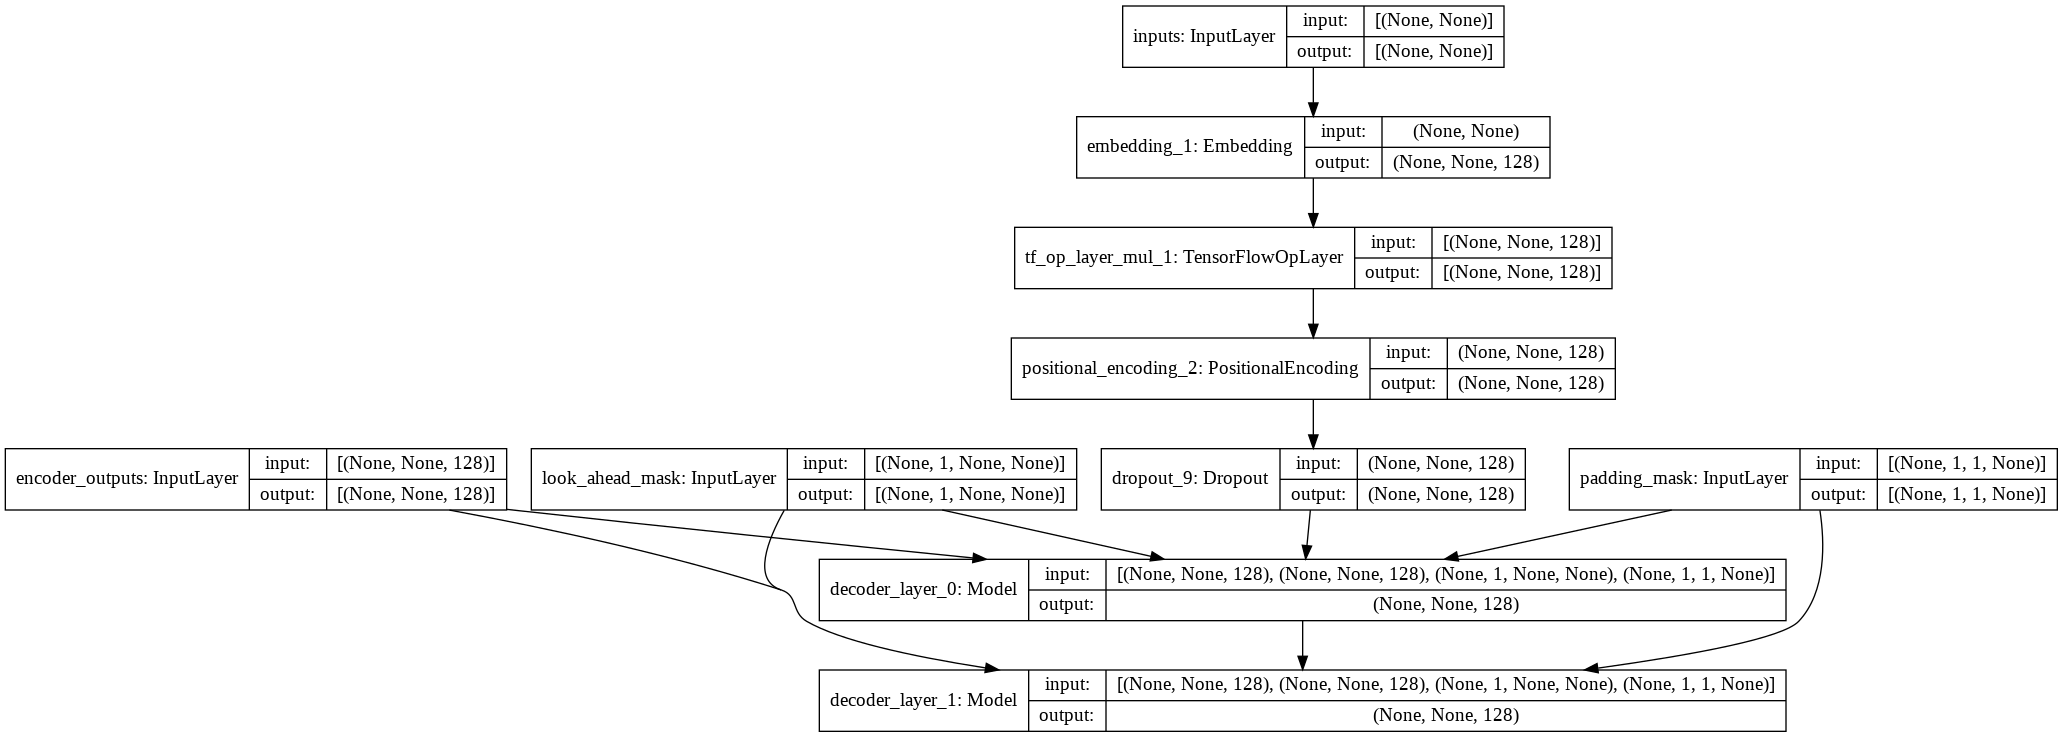

In [24]:
example_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="example_decoder")

tf.keras.utils.plot_model(
    example_decoder, to_file='decoder.png', show_shapes=True)

**Transformer**

The output of the decoder goes through another final linear layer.

In [0]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.layers.Input(shape=(None, ), name='inputs')
  dec_inputs = tf.keras.layers.Input(shape=(None, ), name='dec_inputs')
  enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask,
                                            output_shape=(1, 1, None),
                                            name='enc_padding_mask')(inputs)
  # mask the subsequent tokens for the decoder inputs for 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask,
                                           output_shape=(1, None, None), 
                                           name='look_ahead_mask')(dec_inputs)
  # mask the ecnoder outputs for 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask,
                                            output_shape=(1, 1, None),
                                            name='dec_padding_mask')(inputs)
  enc_outputs = encoder(vocab_size=vocab_size,
                        num_layers=num_layers,
                        units=units,
                        d_model=d_model,
                        num_heads=num_heads,
                        dropout=dropout)(inputs=[inputs,
                                                 enc_padding_mask])
  dec_outputs = decoder(vocab_size=vocab_size,
                        num_layers=num_layers,
                        units=units,
                        d_model=d_model,
                        num_heads=num_heads,
                        dropout=dropout)(inputs=[dec_inputs,
                                                 enc_outputs,
                                                 look_ahead_mask,
                                                 dec_padding_mask])
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
  return tf.keras.Model(inputs=[inputs, dec_inputs], 
                        outputs=outputs,
                        name=name)

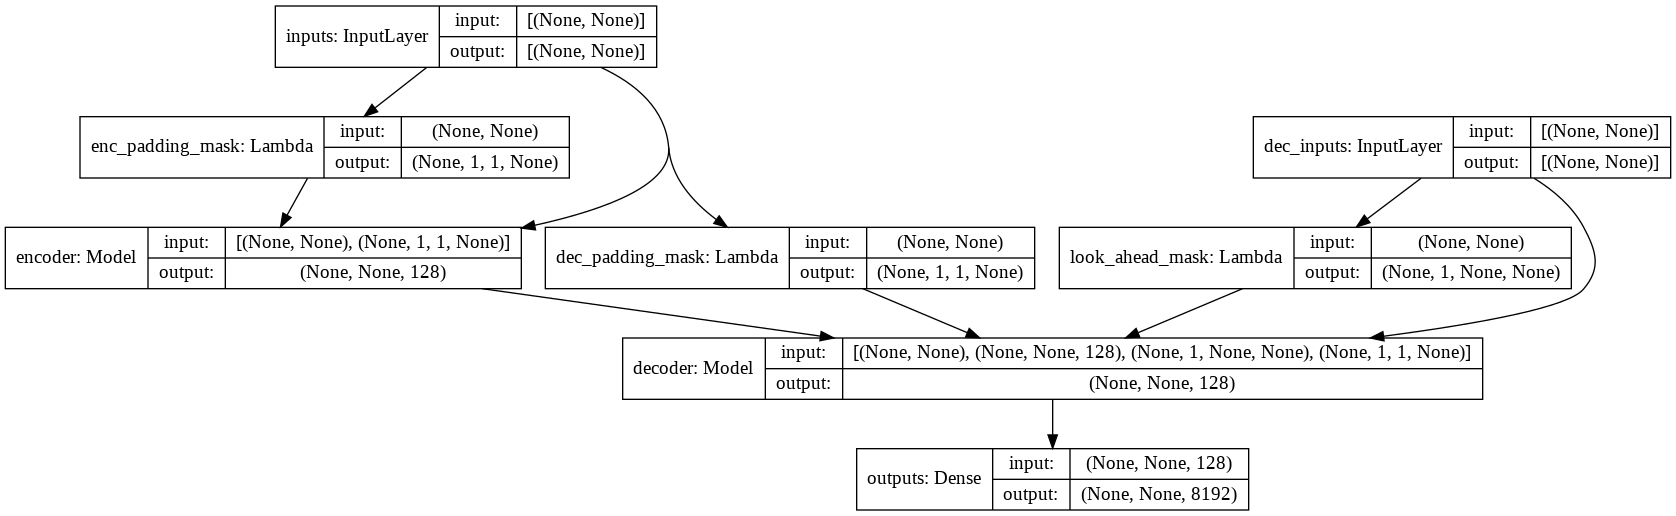

In [26]:
example_transformer = transformer(vocab_size=8192,
                                  num_layers=2,
                                  units=512,
                                  d_model=128,
                                  num_heads=4,
                                  dropout=0.5,
                                  name="example_transformer")
tf.keras.utils.plot_model(example_transformer, to_file='example_transformer.png', show_shapes=True)

In [0]:
# initialise transformer
tf.keras.backend.clear_session()

NUM_LAYERS = 4
D_MODEL = 256
NUM_HEADS = 8
UNITS = 1024
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [0]:
def loss_function(y, y_hat):
  y = tf.reshape(y, shape=(-1, MAX_LENGTH-1))
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                       reduction='none')(y, y_hat)
  mask = tf.cast(tf.not_equal(y, 0), tf.float32)
  loss = tf.multiply(loss, mask)
  return tf.reduce_mean(loss)

class CustomeLearningSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomeLearningSchedule, self).__init__()
    self.d_model = tf.cast(d_model, tf.float32)
    self.warmup_steps = warmup_steps
   
  def __call__(self, step):
    param_1 = tf.math.rsqrt(step)
    param_2 = step * (self.warmup_steps**(-1.5))
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(param_1, param_2)


Text(0.5, 0, 'Train Step')

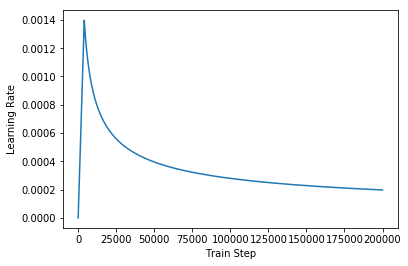

In [29]:

sample_learning_rate = CustomeLearningSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [0]:
lr = CustomeLearningSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

def accuracy(y, y_hat):
  y = tf.reshape(y, shape=(-1, MAX_LENGTH-1))
  acc = tf.metrics.SparseCategoricalAccuracy()(y, y_hat)
  return acc

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [31]:
EPOCHS = 40
model.fit(dataset, epochs=EPOCHS)

Epoch 1/40
689/689 [==============================] - 142s 207ms/step - loss: 2.0063 - accuracy: 0.0345
Epoch 2/40
689/689 [==============================] - 114s 165ms/step - loss: 0.7319 - accuracy: 0.1107
Epoch 3/40
689/689 [==============================] - 114s 166ms/step - loss: 0.2525 - accuracy: 0.1722
Epoch 4/40
689/689 [==============================] - 114s 165ms/step - loss: 0.0782 - accuracy: 0.2099
Epoch 5/40
689/689 [==============================] - 115s 167ms/step - loss: 0.0237 - accuracy: 0.2339
Epoch 6/40
689/689 [==============================] - 114s 166ms/step - loss: 0.0161 - accuracy: 0.2496
Epoch 7/40
689/689 [==============================] - 114s 166ms/step - loss: 0.0114 - accuracy: 0.2604
Epoch 8/40
689/689 [==============================] - 114s 165ms/step - loss: 0.0079 - accuracy: 0.2684
Epoch 9/40
689/689 [==============================] - 114s 165ms/step - loss: 0.0069 - accuracy: 0.2745
Epoch 10/40
689/689 [==============================] - 113s 164m

# EVALUATION


---


Run inference one time step at a time and pass the previous time step's output as input to the next time step.

We can simply call model(inputs, training=False) to run the model in inference mode.

In [0]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)
  sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
  output = tf.expand_dims(START_TOKEN, 0)
  for i in range(MAX_LENGTH):
    predictions = model([sentence, outputs], training=False)
    #select the last word from the seq_len dim
    predictions = predictions[:, -1:, :]
    pred_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # if predicted if is END_TOKEN return
    if pred_id == END_TOKEN[0]:
      break
    
    # concatenate pred_id to the output and feed to the decoder as input
    output = tf.concat([output, pred_id], axis=-1)
  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence  
    